In [1]:
from scipy.stats import bernoulli
import numpy as np
from trueskill import Rating, rate_1vs1, global_env, setup
from utils import ts_win_probability
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# create player pool
possible_opponents = np.random.normal(loc=125.0, scale=10.0, size=99)
opponents_for_games = np.random.choice(possible_opponents, size=500)
game_outcomes = []
win_probabilities = []
elliot_gt_skill = 110
elliot_increment = 10
true_elliot_skill = [elliot_gt_skill]
for index, opponent in enumerate(opponents_for_games):
    if index in [200,300,400]:
        elliot_gt_skill += elliot_increment
    true_elliot_skill.append(elliot_gt_skill)
    
    ewins = 0
    for i in range(1000):
        opponent_perf = np.random.normal(loc=opponent, scale=5.0)
        elliot_perf = np.random.normal(loc=elliot_gt_skill, scale=5.0)
        if elliot_perf > opponent_perf: ewins += 1
    win_probability =  ts_win_probability()  #float(ewins)/1000

    win_probabilities.append(win_probability)
    game_outcomes.append(bernoulli.rvs(win_probability))

In [3]:
print(
    sum(game_outcomes[0:200])/200,
    sum(game_outcomes[201:300])/100,
    sum(game_outcomes[301:400])/100,
    sum(game_outcomes[401:500])/100
)

0.155 0.29 0.69 0.84


In [5]:
mu = 125
sigma = 5
beta = sigma/2
tau = sigma/100
env = setup(mu=mu,sigma=sigma,beta=beta,tau=tau,draw_probability=0)
env

trueskill.TrueSkill(mu=125.000, sigma=5.000, beta=2.500, tau=0.050, draw_probability=0.0%)

In [45]:
e_ts_perf = env.create_rating()
true_skill_mean = [mu]
true_skill_var = [sigma]
for index, opponent in enumerate(opponents_for_games):
    o_ts_perf = env.create_rating(opponent)
    rating_groups = [
        {'elliot'   :  e_ts_perf}, 
        {'opponent' :  o_ts_perf}
    ]
    ranking = [int(not game_outcomes[index]),game_outcomes[index]]
    rated = env.rate(rating_groups, ranks=ranking)
    true_skill_mean.append(rated[0]['elliot'].mu)
    true_skill_var.append(rated[0]['elliot'].sigma)
    e_ts_perf = rated[0]['elliot']


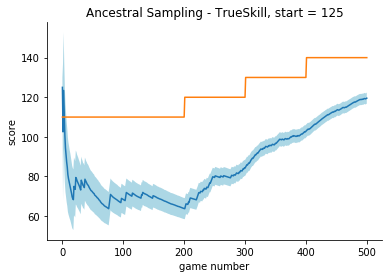

In [46]:
fig, ax = plt.subplots()
error_below = np.array(true_skill_mean)-np.array(true_skill_var)
error_above = np.array(true_skill_mean)+np.array(true_skill_var)
ax.plot(list(range(501)),true_skill_mean)
ax.plot(list(range(501)),true_elliot_skill)
ax.fill_between(list(range(501)), error_below, error_above, facecolor=(173/256, 216/256, 230/256))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Ancestral Sampling - TrueSkill, start = 125')
ax.set_xlabel('game number')
ax.set_ylabel('score')
plt.savefig('ts_synth.png')

In [7]:
from model_params import mov_exp, mov_lin
from models import DynamicElo

In [37]:
base_k = 2
cutoff = 1650
reduction = 0.75
mov = mov_lin
w90 = 100
elo = DynamicElo(base_k, cutoff, reduction, mov, w90)

In [38]:
possible_opponents = np.random.normal(loc=1500.0, scale=(1500.0/12.5), size=99)
opponents_for_games = np.random.choice(possible_opponents, size=500)
game_outcomes = []
win_probabilities = []
skill_start = 1320.
elliot_increment = (1500.0/12.5)
elliot_gt_skill = skill_start
true_elliot_skill = [skill_start]
for index, opponent in enumerate(opponents_for_games):
    if index in [200,300,400]:
        elliot_gt_skill += elliot_increment
    true_elliot_skill.append(elliot_gt_skill)
    win_probability = elo.calc_win_prob(elliot_gt_skill,opponent)
    win_probabilities.append(win_probability)
    game_outcomes.append(bernoulli.rvs(win_probability))

In [39]:
print(
    sum(game_outcomes[0:200])/200,
    sum(game_outcomes[201:300])/100,
    sum(game_outcomes[301:400])/100,
    sum(game_outcomes[401:500])/100
)

0.165 0.43 0.65 0.9


In [40]:
elliot = 1500.
elos = [elliot]
for index, opponent in enumerate(opponents_for_games):
#     print(elliot, opponent)
    if game_outcomes[index] == 1:
        elliot, opponent = elo.update(elliot, opponent, 3, 2) 
    else:
        opponent, elliot = elo.update(opponent, elliot, 3, 2)
    elos.append(elliot)
    

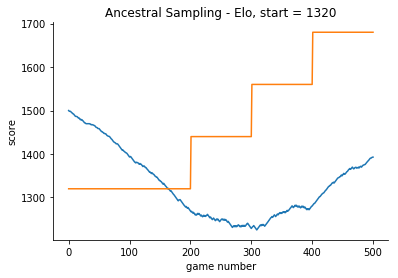

In [41]:
fig, ax = plt.subplots()
ax.plot(list(range(501)),elos)
ax.plot(list(range(501)),true_elliot_skill)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Ancestral Sampling - Elo, start = 1320')
ax.set_xlabel('game number')
ax.set_ylabel('score')
plt.savefig('elo_synth.png')